<a href="https://colab.research.google.com/github/lubianat/ann/blob/main/hypothesis_wikidata_annotations_parsing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wikidata2df
import requests
import pandas as pd
import wikidata2df
import time
import re

def get_chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [ ]:
def get_annotations_from_hypothesis(europe_pmc_url):
  """
  Gets all annotations on Hypothes.is for a page on Europe PMC
  """
  offset = 0
  while True:
      time.sleep(1)
      print("offset: " + str(offset))
      query_params = {"url":europe_pmc_url,
                  "offset":str(offset),
                  "limit":"200"}
      result = requests.get("https://api.hypothes.is/api/search", params = query_params)
      df_now = pd.json_normalize(result.json()['rows'])

      if offset == 0:
          df = df_now
      else:
          df = df.append(df_now)


      if len(df_now) != 200:
        break

      offset += 200

  return(df)

def get_types_of_qids(list_of_qids):
  """
  Attributes
    list_of_qids (str): A list of Wikidata QIDs

  Returns
    pd.DataFrame: The qids, their labels, their types, and the labels of the types
  """
  list_of = []
  i = 0
  for qid_values in list_of_qids:
          i+=1
          query = """

          SELECT ?item ?itemLabel ?superclass ?superclassLabel ?type ?typeLabel
          WHERE{
          VALUES ?item {""" + " ".join(qid_values) +"""}
          OPTIONAL{?item wdt:P31 ?type.}
          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }

          }
          """
          if i == 1:
              expanded_qid_type_table = wikidata2df.wikidata2df(query)
          else:
              result_now =  wikidata2df.wikidata2df(query)
              expanded_qid_type_table = expanded_qid_type_table.append(result_now)

  return expanded_qid_type_table



def get_types_and_annotations(europe_pmc_url):
  df = get_annotations_from_hypothesis(europe_pmc_url)
  print(df)
  wikidata_ids = df["text"]

  wikidata_ids = wikidata_ids[["entity/Q" in value for value in wikidata_ids]]
  wikidata_ids = [value.replace("\n", "") for value in wikidata_ids]
  wikidata_unique_ids = list(set(wikidata_ids))
  qid_values = [re.sub(".*Q","wd:Q", qid) for qid in wikidata_unique_ids]  

  qid_values_list = get_chunks(qid_values, 400)
  expanded_qid_type_table = get_types_of_qids(qid_values_list)  

  expanded_qid_type_table["url"] = europe_pmc_url
  return expanded_qid_type_table

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
spreadsheet_name = "ANN MiniCorpus 0.1"
sh = gc.open(spreadsheet_name)
worksheet = sh.sheet1
print("https://docs.google.com/spreadsheets/d/%s" % sh.id)
list_of_lists = worksheet.get_all_values()
articles = pd.DataFrame(list_of_lists)

https://docs.google.com/spreadsheets/d/1hVSV4IlElqjQWRE55EOD-OrQlLWvlGKzRlD6SCF1FV0


In [ ]:
new_header = articles.iloc[0] #grab the first row for the header
articles = articles[1:] #take the data less the header row
articles.columns = new_header #set the header row as the df header

In [ ]:
list_of_europe_pmc_urls = articles["Europe PMC link"]
list_of_europe_pmc_urls

1      https://europepmc.org/article/MED/29206104
2      https://europepmc.org/article/MED/29072289
3      https://europepmc.org/article/MED/30348985
4      https://europepmc.org/article/MED/30096314
5      https://europepmc.org/article/MED/30429548
                         ...                     
66     https://europepmc.org/article/MED/33384458
67    https://europepmc.org/article/PPR/PPR289457
68    https://europepmc.org/article/PPR/PPR308125
69    https://europepmc.org/article/PPR/PPR306786
70    https://europepmc.org/article/PPR/PPR308216
Name: Europe PMC link, Length: 70, dtype: object

In [ ]:
def get_types_and_annotations_from_multiple_pages(list_of_europe_pmc_urls):
  """
  Gets all annotations on Hypothes.is and their Wikidata types for many pages
  """
  i = 0
  for europe_pmc_url in list_of_europe_pmc_urls:
      time.sleep(1)
      try:
        df_now = get_types_and_annotations(europe_pmc_url)

        if i == 0:
            df = df_now
            print(df)
        else:
            df = df.append(df_now)
        i += 1
      except:
        pass
  return df


In [ ]:
annotations = get_types_and_annotations_from_multiple_pages(list_of_europe_pmc_urls)

offset: 0
offset: 200
offset: 400
offset: 600
offset: 800
offset: 1000
offset: 1200
offset: 1400
offset: 1600
offset: 1800
offset: 2000
offset: 2200
                         id  ... user_info.display_name
0    1-tb-p1qEeu30zePqW-14g  ...                   None
1    z2yJIp1qEeubCa91en77eg  ...                   None
2    x1PgZJ1qEeuITm943pIWOg  ...                   None
3    qciOAJ1qEeuub48SSZjplA  ...                   None
4    oqOo5J1qEeubB1eMtILrMg  ...                   None
..                      ...  ...                    ...
146  vEPk1EYnEeuYYI98irmdNw  ...                   None
147  qcJ07EYnEeu3S2N82_kdNw  ...                   None
148  n_loxkYnEeuZYc8GekOp9A  ...                   None
149  kDQvSEYnEeuSamMykNVrZQ  ...                   None
150  cM69MEYnEeuUsk-V4UPtXA  ...                   None

[2351 rows x 20 columns]
          type  ...                                         url
0    Q55983715  ...  https://europepmc.org/article/MED/29206104
1         Q515  ...  http

In [ ]:
annotations

,type,itemLabel,item,typeLabel,url
0,Q55983715,human,Q5,organisms known by a particular common name,https://europepmc.org/article/MED/29206104
1,Q515,New York City,Q60,city,https://europepmc.org/article/MED/29206104
2,Q208511,New York City,Q60,global city,https://europepmc.org/article/MED/29206104
3,Q1093829,New York City,Q60,city of the United States,https://europepmc.org/article/MED/29206104
4,Q1549591,New York City,Q60,big city,https://europepmc.org/article/MED/29206104
...,...,...,...,...,...
35,None,damage recognition receptor,Q106908612,None,https://europepmc.org/article/PPR/PPR308216
36,None,oral mucosal homeostasis,Q106908629,None,https://europepmc.org/article/PPR/PPR308216
37,None,oral mucosal inflammation,Q106908634,None,https://europepmc.org/article/PPR/PPR308216
38,None,stromal–immune interaction,Q106908639,None,https://europepmc.org/article/PPR/PPR308216


In [ ]:
annotations.to_csv("hypothesis_annotations.csv")

In [1]:
# https://stackoverflow.com/questions/54595285/how-to-use-r-with-google-colaboratory
%load_ext rpy2.ipython

In [29]:
%%R
library(dplyr)
x <- read.csv("hypothesis_annotations.csv")
x["X"] <- NULL
print(head(x))
hca_annotations = x %>% dplyr::filter(url == "https://europepmc.org/article/MED/29206104")

abstract_annotations = x %>% dplyr::filter(url != "https://europepmc.org/article/MED/29206104")



       type     itemLabel item                                   typeLabel
1 Q55983715         human   Q5 organisms known by a particular common name
2      Q515 New York City  Q60                                        city
3   Q208511 New York City  Q60                                 global city
4  Q1093829 New York City  Q60                   city of the United States
5  Q1549591 New York City  Q60                                    big city
6  Q1637706 New York City  Q60           city with millions of inhabitants
                                         url
1 https://europepmc.org/article/MED/29206104
2 https://europepmc.org/article/MED/29206104
3 https://europepmc.org/article/MED/29206104
4 https://europepmc.org/article/MED/29206104
5 https://europepmc.org/article/MED/29206104
6 https://europepmc.org/article/MED/29206104


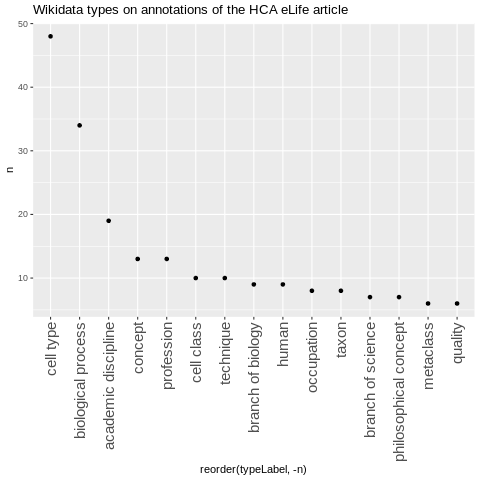

In [48]:
%%R
library(ggplot2)

head(hca_annotations %>% 
    filter(typeLabel !="") %>%
    count(typeLabel, sort = TRUE), 15) %>% 
    ggplot(aes(x=reorder(typeLabel, -n), y=n)) + 
    geom_point() + 
    theme(axis.text.x = element_text(size = 15,angle = 90, vjust = 0.5, hjust=1)) +
    ggtitle("Wikidata types on annotations of the HCA eLife article")



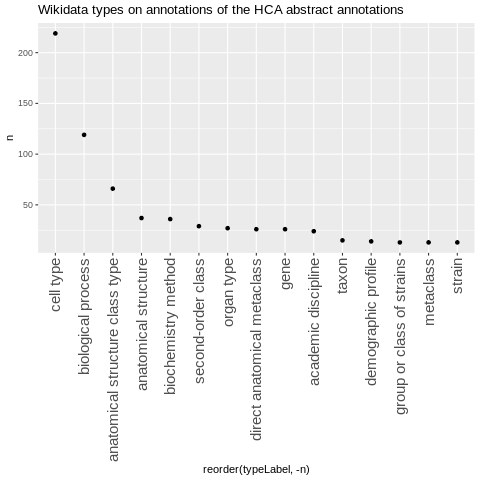

In [49]:
%%R
head(abstract_annotations %>% 
    filter(typeLabel !="") %>%
    count(typeLabel, sort = TRUE), 15) %>% 
    ggplot(aes(x=reorder(typeLabel, -n), y=n)) + 
    geom_point() + 
    theme(axis.text.x = element_text(size = 15,angle = 90, vjust = 0.5, hjust=1)) +
    ggtitle("Wikidata types on annotations of the HCA abstract annotations")

# Annotations are unique per article, but not over all articles!


In [50]:
%%R
head(hca_annotations %>% dplyr::filter(typeLabel == "cell type"), 15)

      type                    itemLabel       item typeLabel
1  Q189118                T-lymphocytes    Q193529 cell type
2  Q189118                Purkinje cell   Q1570272 cell type
3  Q189118                     myoblast   Q1956694 cell type
4  Q189118       hepatic stellate cells   Q1997459 cell type
5  Q189118                   brain cell   Q3243699 cell type
6  Q189118             endothelial cell  Q11394395 cell type
7  Q189118 cancer-associated fibroblast  Q42417562 cell type
8  Q189118               nucleated cell  Q47088881 cell type
9  Q189118                  neural cell  Q66568342 cell type
10 Q189118                    Th2 cells  Q67101694 cell type
11 Q189118   mouse embryonic stem cells  Q70060965 cell type
12 Q189118              retinal neurons  Q70188529 cell type
13 Q189118                   human cell  Q75402508 cell type
14 Q189118                  immune cell Q104524156 cell type
15 Q189118     inhibitory cortical cell Q105745873 cell type
                        

In [33]:
%%R
head(hca_annotations %>% dplyr::filter(typeLabel == "human"), 15)

  type                itemLabel    item typeLabel
1   Q5             Robert Remak  Q62088     human
2   Q5           Rudolf Virchow  Q76432     human
3   Q5          Theodor Schwann  Q76745     human
4   Q5 Matthias Jacob Schleiden  Q76747     human
5   Q5             Robert Hooke  Q46830     human
6   Q5   Santiago Ramón y Cajal Q150526     human
7   Q5            Ronald Fisher Q216723     human
8   Q5        Jorge Luis Borges    Q909     human
9   Q5            Camillo Golgi Q150630     human
                                         url
1 https://europepmc.org/article/MED/29206104
2 https://europepmc.org/article/MED/29206104
3 https://europepmc.org/article/MED/29206104
4 https://europepmc.org/article/MED/29206104
5 https://europepmc.org/article/MED/29206104
6 https://europepmc.org/article/MED/29206104
7 https://europepmc.org/article/MED/29206104
8 https://europepmc.org/article/MED/29206104
9 https://europepmc.org/article/MED/29206104


In [26]:
%%R
head(abstract_annotations %>% dplyr::filter(typeLabel == "cell type"), 15)

    X    type              itemLabel       item typeLabel
1   7 Q189118               monocyte    Q107244 cell type
2   9 Q189118             macrophage    Q184204 cell type
3  10 Q189118                 B-cell    Q188930 cell type
4  11 Q189118          T-lymphocytes    Q193529 cell type
5  15 Q189118             hepatocyte    Q827450 cell type
6  21 Q189118 hepatic stellate cells   Q1997459 cell type
7  22 Q189118       endothelial cell  Q11394395 cell type
8  31 Q189118           NK-like cell Q104514469 cell type
9  32 Q189118          resident cell Q104514674 cell type
10  4 Q189118                 neuron     Q43054 cell type
11 12 Q189118              astrocyte    Q502961 cell type
12 19 Q189118        oligodendrocyte    Q916698 cell type
13  4 Q189118             blood cell    Q211709 cell type
14 14 Q189118           stromal cell   Q4381253 cell type
15 17 Q189118       trophoblast cell  Q66589800 cell type
                                          url
1  https://europepmc.org/a

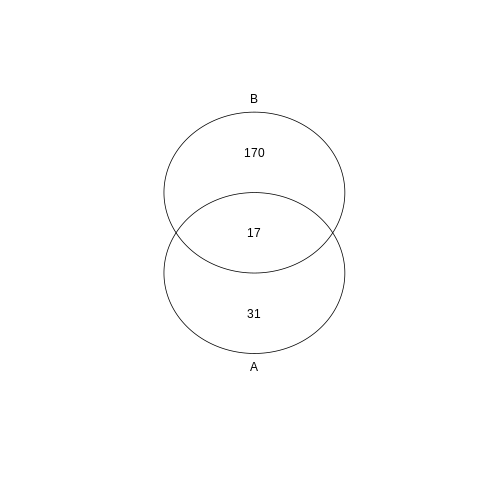

In [63]:
%%R
#install.packages("gplots")
library(gplots)

hca_cells = hca_annotations %>% dplyr::filter(typeLabel == "cell type")
abstract_cells = abstract_annotations %>% dplyr::filter(typeLabel == "cell type") 
set.seed(20190708)
genes <- paste("gene",1:1000,sep="")
x <- list(
  A = hca_cells %>% pull(itemLabel), 
  B = abstract_cells %>% pull(itemLabel)
  )
v.table <- venn(x)

In [70]:
%%R
intersections = (attr(v.table,"intersections"))

print(intersections$`A:B`)

 [1] "T-lymphocytes"          "Purkinje cell"          "hepatic stellate cells"
 [4] "endothelial cell"       "Th2 cells"              "human cell"            
 [7] "immune cell"            "B-cell"                 "T helper cell"         
[10] "Naive T cell"           "epithelial cell"        "neuron"                
[13] "plasma cell"            "megakaryocyte"          "progenitor cell"       
[16] "stromal cell"           "flow-sorted cell"      


In [64]:
%%R
hca_cells

      type                                     itemLabel       item typeLabel
1  Q189118                                 T-lymphocytes    Q193529 cell type
2  Q189118                                 Purkinje cell   Q1570272 cell type
3  Q189118                                      myoblast   Q1956694 cell type
4  Q189118                        hepatic stellate cells   Q1997459 cell type
5  Q189118                                    brain cell   Q3243699 cell type
6  Q189118                              endothelial cell  Q11394395 cell type
7  Q189118                  cancer-associated fibroblast  Q42417562 cell type
8  Q189118                                nucleated cell  Q47088881 cell type
9  Q189118                                   neural cell  Q66568342 cell type
10 Q189118                                     Th2 cells  Q67101694 cell type
11 Q189118                    mouse embryonic stem cells  Q70060965 cell type
12 Q189118                               retinal neurons  Q70188